<h1><center> Large Scale Kernel Methods </center></h1>
<center> Overcoming scaling issues of Support Vector Machines (and others) </center>

# I. Import

In [32]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from time import time
from math import pi
plt.style.use('ggplot')

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC, LinearSVC

from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot
from numpy.linalg import norm

# II. Generate data

In [11]:
X, y = make_classification(n_samples=100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Training samples :", n1)
print("Test samples:", n2)
print("Features:", p)

Training samples : 75000
Test samples: 25000
Features: 20


# III. Linear SVC

In [13]:
# Train
t0 = time()
clf_lin = LinearSVC(dual=False)
clf_lin.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 0.334s


In [14]:
# Test
t1 = time()
timing_linear = time() - t1
y_pred = clf_lin.predict(X_test)
print("done in %0.3fs" % (time() - t1))

done in 0.016s


In [15]:
# Accuracy
accuracy_linear = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_linear)

classification accuracy: 0.868


# IV. Gaussian Kernel SVC

In [16]:
# Train
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 375.102s


In [17]:
# Test
t1 = time()
y_pred = clf.predict(X_test)
timing_kernel = time() - t1
print("done in %0.3fs" % (time() - t1))

done in 40.148s


In [18]:
# Accuracy
accuracy_kernel = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)

classification accuracy: 0.891


# Random Kernel Features

In [19]:
def rank_trunc(gram_mat, k):
    
    u, s, vt = svds(gram_mat, k=k)
    gram_mat_k = np.dot(u, np.dot(np.diag(s), vt))

    return gram_mat_k

In [20]:
def random_features(X_train, X_test, gamma, c=300, seed=42):

    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    W = np.random.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = np.random.uniform(0, 2*pi, (1,c))

    X_new_train = np.sqrt(2/n_features) * np.cos(np.dot(X_train, W) + b)
    X_new_test = np.sqrt(2/n_features) * np.cos(np.dot(X_test, W) + b)

    return X_new_train, X_new_test

In [ ]:
n_samples, n_features = X_train.shape
gamma = 1. / n_features

In [ ]:
Z_train, Z_test = random_features(X_train, X_test, gamma, c=800)

In [23]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 39.525s
done in 0.089s
classification accuracy: 0.881


In [ ]:
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)

# Nyström Approximation

In [33]:
def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):

    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]

    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]
    
    M = np.dot(u, np.diag(1/np.sqrt(s)))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(C_train, M)
    X_new_test = np.dot(C_test, M)
    
    return X_new_train, X_new_test

In [34]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

In [35]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 15.260s


In [36]:
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)

done in 0.021s
classification accuracy: 0.886


# Performance Overview

In [38]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rbf = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    
    print(i, c)

    ## Nystorm
    Z_ny_train, Z_ny_test = nystrom(X_train, X_test, gamma, c=c, k=300, seed=44)

    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_ny_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_ny_test, y_test)
    timing_nystrom[i] = time() - t0

    ## Random Kernel Feature
    Z_rkf_train, Z_rkf_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_rkf_train, y_train)
    accuracy_rkf[i] = clf.score(Z_rkf_test, y_test)
    timing_rkf[i] = time() - t0

    ## Linear
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    accuracy_linear[i] = clf.score(X_test, y_test)
    timing_linear[i] = time() - t0
    
    ## RBF
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    accuracy_rbf[i] = clf.score(X_test, y_test)
    timing_rbf[i] = time() - t0

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


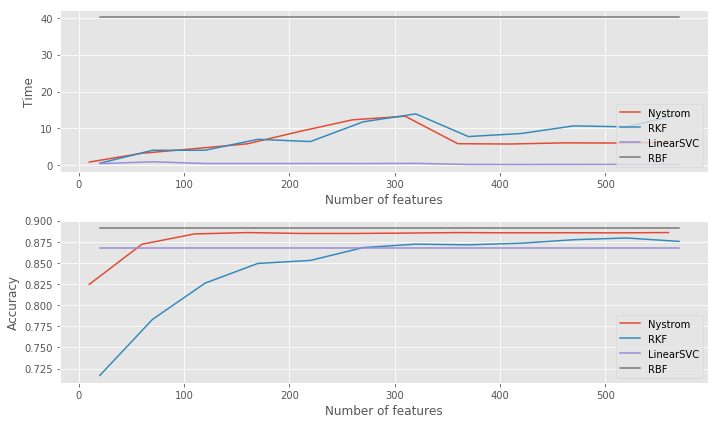

In [39]:
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()